In [120]:
import torch

import triton
import triton.language as tl
from triton.runtime import driver
DEVICE = triton.runtime.driver.active.get_active_torch_device()

In [121]:
def naive_softmax(x:torch.Tensor) -> torch.Tensor:
    # N (row) * M (col) softmax
    x_max = x.max(dim=1)[0] # NM reads (max of each row), M writes
    z = x - x_max[:,None] #  NM writes, NM + M read
    numerator = torch.exp(z) # NM reads, NM writes
    denominator = numerator.sum(dim=1) # N writes, NM reads
    ret = numerator / denominator[:,None] # NM writes, NM + m reads
    return ret

SIZE =5
x = torch.rand([SIZE,SIZE])
x_out = naive_softmax(x)

def assert_softmax_row_sum_one(x):
    return torch.allclose(x.sum(dim=1),torch.ones_like(x.sum(dim=1)))
assert_softmax_row_sum_one(x_out)

True

In [122]:
@triton.jit
def softmax_kernel(output_ptr,input_ptr,input_row_strides,output_row_strides,n_rows,n_cols,BLOCK_SIZE:tl.constexpr,num_stages:tl.constexpr):
    #idx of starting row
    row_start = tl.program_id(axis=0)
    #num of rows until the next program (row_start + row_step*input_row_strides)
    row_step = tl.num_programs(axis=0)

    for row_idx in tl.range(row_start,n_rows,row_step,num_stages=num_stages):
        row_start_ptr = input_ptr + (row_idx * input_row_strides) # start of data + the offset to get to the current read
        #NOTE: limitation of triton is block sizes must be a power of 2. e.g block size is always the next bigger power of 2 value above the amount you need
        # so in this case it will be the next power of 2 above num of columns
        col_offsets = tl.arange(0,BLOCK_SIZE)

        # create ptrs to each element within the current row
        input_ptrs = row_start_ptr + col_offsets

        mask = col_offsets < n_cols

        row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
        row_minus_max = row - tl.max(row, axis=0)
        # NOTE: exp in tl is approximate (similar to __expf in cuda)
        numerator = tl.exp(row_minus_max)
        denominator = tl.sum(numerator,axis=0)
        softmax_out = numerator / denominator
        output_row_start_ptr = output_ptr + (row_idx * output_row_strides)
        output_ptrs = output_row_start_ptr +  col_offsets
        tl.store(output_ptrs,softmax_out,mask=mask)


In [123]:
@triton.jit
def softmax_kernel_single_row(output_ptr,input_ptr,input_row_strides,output_row_strides,n_rows,n_cols,BLOCK_SIZE:tl.constexpr,num_stages:tl.constexpr):
    #idx of starting row
    row_start = tl.program_id(axis=0)
    data_start = row_start * n_cols

    col_offsets = tl.arange(0,BLOCK_SIZE)

    input_ptrs = input_ptr + (row_start * input_row_strides) + col_offsets
    mask = col_offsets < n_cols

    row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
    row_minus_max = row - tl.max(row, axis=0)

    numerator = tl.exp(row_minus_max)
    denominator = tl.sum(numerator,axis=0)
    softmax_out = numerator / denominator
    output_ptrs = output_ptr + (row_start * output_row_strides) +   col_offsets
    tl.store(output_ptrs,softmax_out,mask=mask)

In [6]:
from enum import StrEnum

properties = driver.active.utils.get_device_properties(DEVICE.index)
print(f'{properties=}')

NUM_SM = properties['multiprocessor_count']
NUM_REGS = properties['max_num_regs']
SIZE_SMEM = properties['max_shared_mem']
WARP_SIZE = properties['warpSize']
target = triton.runtime.driver.active.get_current_target()
print(f'{target=}')
kernels = {}


class SoftmaxKernel(StrEnum):
    """Kernel selection: ROW_BLOCK = multi-row per program, SINGLE_ROW = one row per program."""
    ROW_BLOCK = "row_block"
    SINGLE_ROW = "single_row"


def softmax(x, kernel_type: SoftmaxKernel = SoftmaxKernel.SINGLE_ROW):
    n_rows, n_cols = x.shape
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    num_warps = 8
    num_stages = 4 if SIZE_SMEM > 200_000 else 2

    y = torch.empty_like(x)

    if kernel_type == SoftmaxKernel.SINGLE_ROW:
        kernel_fn = softmax_kernel_single_row
        warmup_grid = (1,)
    else:
        kernel_fn = softmax_kernel
        warmup_grid = (1,)

    kernel = kernel_fn.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE, num_stages=num_stages, num_warps=num_warps, grid=warmup_grid)
    kernel._init_handles()
    n_regs = kernel.n_regs
    size_smem = kernel.metadata.shared

    occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    if size_smem > 0:
        occupancy = min(occupancy, SIZE_SMEM // size_smem)

    num_programs = NUM_SM * occupancy
    num_programs = min(num_programs, n_rows)

    if kernel_type == SoftmaxKernel.SINGLE_ROW:
        kernel[(n_rows, 1, 1)](y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE, num_stages)
    else:
        kernel[(num_programs, 1, 1)](y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE, num_stages)
    return y

x = torch.randn([320, 320], device=DEVICE)
y = softmax(x)
assert_softmax_row_sum_one(softmax(x))


properties={'max_shared_mem': 65536, 'max_num_regs': 65536, 'multiprocessor_count': 40, 'warpSize': 32, 'sm_clock_rate': 1590000, 'mem_clock_rate': 5001000, 'mem_bus_width': 256}
target=GPUTarget(backend='cuda', arch=75, warp_size=32)


True

## Note

The occupancy calculation is essentially finding the num of programs needed to cover the limiting factor in occupancy, e.g if we only use 1/10th the total number of registers in each SM, we could justify launching 10 programs. if SMEM was the limiting factor at say 1/2, we would only need to load 2. any more than this would be pointless in the sens that occupancy is alreday at ~100. 

`min(num_programs, n_rows)` is a catch-all, if we decide we needed 200 programs, but we only had 100 rows of data, we should ofcourse only launch a max of 100 programs since the program is essentially set up at the row-level (we should just not have any coarsing)

In [7]:
def test_softmax_padding():
    torch.manual_seed(0)
    x = torch.randn(1823, 781, device=DEVICE)
    y_triton = softmax(x, kernel_type=SoftmaxKernel.ROW_BLOCK)
    y_torch = torch.softmax(x, axis=1)
    assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)
test_softmax_padding()

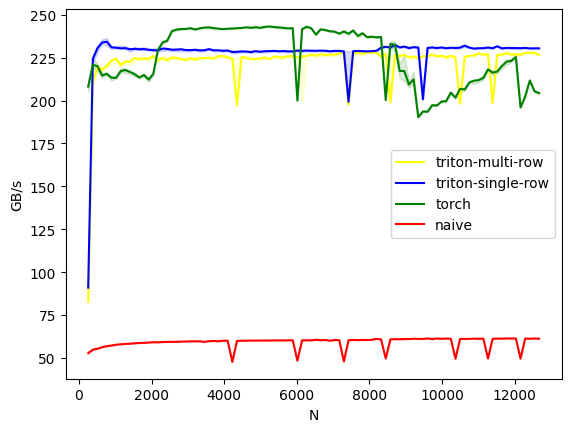

softmax-performance:
          N  triton-multi-row  triton-single-row       torch      naive
0     256.0         82.956960          90.990627  208.133379  52.777130
1     384.0        210.388440         224.310330  220.783829  54.815083
2     512.0        219.919464         230.557599  220.011751  55.380584
3     640.0        217.872334         233.806642  214.555575  56.263735
4     768.0        220.104116         234.266313  215.578943  56.862154
5     896.0        223.182688         231.051109  213.273818  57.225974
6    1024.0        224.390318         230.760556  213.211866  57.699665
7    1152.0        220.577403         230.400006  217.166424  57.962263
8    1280.0        222.703254         230.517060  217.763741  58.181818
9    1408.0        222.567460         229.877559  216.615387  58.275414
10   1536.0        224.791190         230.152770  215.328083  58.564397
11   1664.0        224.143116         229.857821  213.392122  58.710862
12   1792.0        224.410906         230.0

In [8]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[128 * i for i in range (2,100)],
        line_arg='provider',
        line_vals=['triton-multi-row','triton-single-row','torch','naive'],
        line_names=['triton-multi-row','triton-single-row','torch','naive'],
        styles = [('yellow','-'),('blue','-'),('green','-'),('red','-')],
        ylabel='GB/s',
        plot_name = 'softmax-performance',
        args={'M':4096}
    )
)
def benchmark(M,N,provider):
    quantiles = [0.5,0.2,0.8]
    x=torch.randn(M,N,device=DEVICE,dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms,min_ms,max_ms = triton.testing.do_bench(lambda: torch.softmax(x,axis=1),quantiles=quantiles)
    if provider == 'triton-single-row':
        ms,min_ms,max_ms = triton.testing.do_bench(lambda: softmax(x,kernel_type=SoftmaxKernel.SINGLE_ROW),quantiles=quantiles)
    if provider == 'triton-multi-row':
        ms,min_ms,max_ms = triton.testing.do_bench(lambda: softmax(x,kernel_type=SoftmaxKernel.ROW_BLOCK),quantiles=quantiles)
    if provider == 'naive':
        ms,min_ms,max_ms = triton.testing.do_bench(lambda: naive_softmax(x),quantiles=quantiles)
    gbps = lambda ms: 2*x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms),gbps(min_ms),gbps(max_ms)

benchmark.run(show_plots=True,print_data=True)

## Notes 

As a test I implemented the same kernel but enforcing a single row of data per program. Interestingly we saw speed gains from this compared to the multi-row example. I think the reason for this is simple; we have so far only tested this on a gtx1080, and a L4 tensor GPU. Neither of these allow of async copies to shared memory, e.g we are not able to make use of the memory bandwidth speed up from using num_stages > 1. I think we would see speed ups with this for cases where thread coarsening is needed. this should be confirmed by running it on a H100.

github discussion talking about what num_stages does: https://github.com/triton-lang/triton/discussions/512